# PM10 Experiment
This notebook contains the code for the semi-synthetic data experiment that I conducted on the PM10 dataset.

In [1]:
import sys 
sys.path.append('..')

import cox
from cox.store import Store
from cox.utils import Parameters
from cox.readers import CollectionReader
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import math
from sklearn.metrics import r2_score
import os
import datetime
from sklearn.datasets import load_boston
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D 
import subprocess
import IPython
import matplotlib.patches as mpatches

from delphi import oracle 
from delphi.stats.linear_regression import TruncatedRegression

TABLE_NAME = 'logs'
COMMAND = 'RScript'

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'

# mean squared error loss
mse_loss = ch.nn.MSELoss()

In [294]:
args = Parameters({
    "bs": 10,
    "trials": 10,
    "steps": 2500,
    "table_name": 'results', 
    'tol': 1e-2,
    'n': 100,
    'lr': 1e-1,
    'step_lr': 100, 
    'step_lr_gamma': .9,
    'attempts': 3, 
    'val': .2,
    "out_dir": '/Users/patroklos/Desktop/bootstrap_random', # where to write results to
    "dataset": './pm10.csv',
    "exp": 'BoostrapExpRand10', # experiment name
    "n_boots": 10
})

# Import Dataset into Notebook
The fist thing that we nned to do is import the dataset. To do this, you can either provide the path to your dataset, including the filename to the $\textit{dataset}$ key of the args dictionary.

In [3]:
df = pd.read_csv(args.dataset)
df.head()

,pm10_concentration,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,day
0,3.66356,7.74414,-4.4,4.2,0.0,18.0,19,116
1,3.04452,8.03398,-5.7,4.8,-0.3,69.1,9,506
2,3.71357,4.70048,-13.5,4.3,0.2,80.0,3,95
3,2.94444,7.52510,1.4,3.0,0.1,177.0,22,161
4,4.06044,7.76260,4.1,5.6,1.1,287.0,7,80


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
pm10_concentration         500 non-null float64
cars_per_hour              500 non-null float64
temperature_at_2m          500 non-null float64
wind_speed                 500 non-null float64
temperature_diff_2m_25m    500 non-null float64
wind_direction             500 non-null float64
hour_of_day                500 non-null int64
day                        500 non-null int64
dtypes: float64(6), int64(2)
memory usage: 31.4 KB


# Data Exploration
For this regression task, we want to predict the PM10 concentratioin in the air at the specific time of a day. PM concentration is measure of the particulate matter in the air that has a diameter of less that 10 micrometers. And particulate matter is everything in the air that is not a gas and therefore consists of a huge variety of chemical compounds and materials. Now, the first thing that we want to do after extracting our data from csv file, is check whether our dependent variable is normally distibuted. When we plot our histogram, we see that in fact is normally distributed.

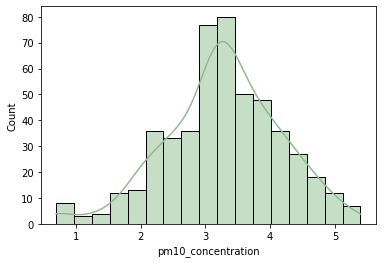

In [5]:
sns.histplot(data=df, x='pm10_concentration', kde=True, color="darkseagreen")

Now, that we know that our dependent variable is normally distributed, the next step is extracting the features that we want to use for our inputs. To do this, we want to determine which independent variables have a correlation with the PM10 concentration. The first thing that we do is create a correlation matrix to see the Pearson correlation's that the independent variables have with respect to one another.

In [6]:
corr_matrix = df.corr()
corr_matrix

,pm10_concentration,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,day
pm10_concentration,1.000000,0.355607,0.046287,-0.145214,-0.071561,0.016439,0.213435,0.045819
cars_per_hour,0.355607,1.000000,0.257275,0.186776,-0.346744,0.008911,0.555063,-0.002579
temperature_at_2m,0.046287,0.257275,1.000000,0.213626,-0.358029,0.321139,0.119237,0.161279
wind_speed,-0.145214,0.186776,0.213626,1.000000,-0.272142,-0.091684,0.032277,0.040603
temperature_diff_2m_25m,-0.071561,-0.346744,-0.358029,-0.272142,1.000000,-0.041507,-0.069560,-0.142914
wind_direction,0.016439,0.008911,0.321139,-0.091684,-0.041507,1.000000,0.036591,0.044858
hour_of_day,0.213435,0.555063,0.119237,0.032277,-0.069560,0.036591,1.000000,-0.049054
day,0.045819,-0.002579,0.161279,0.040603,-0.142914,0.044858,-0.049054,1.000000


After examining the correlation matrix, we notice that the features taht are the most correlated to the PM10 concentration are cars per hour and wind speed. Further, we see that windspeed and cars per hour have a correlation of .186776, which is very small. Implying that there there are no multicollinearity issue with our regression setup. We now create a pairplot to further evaluate relationships between the features.

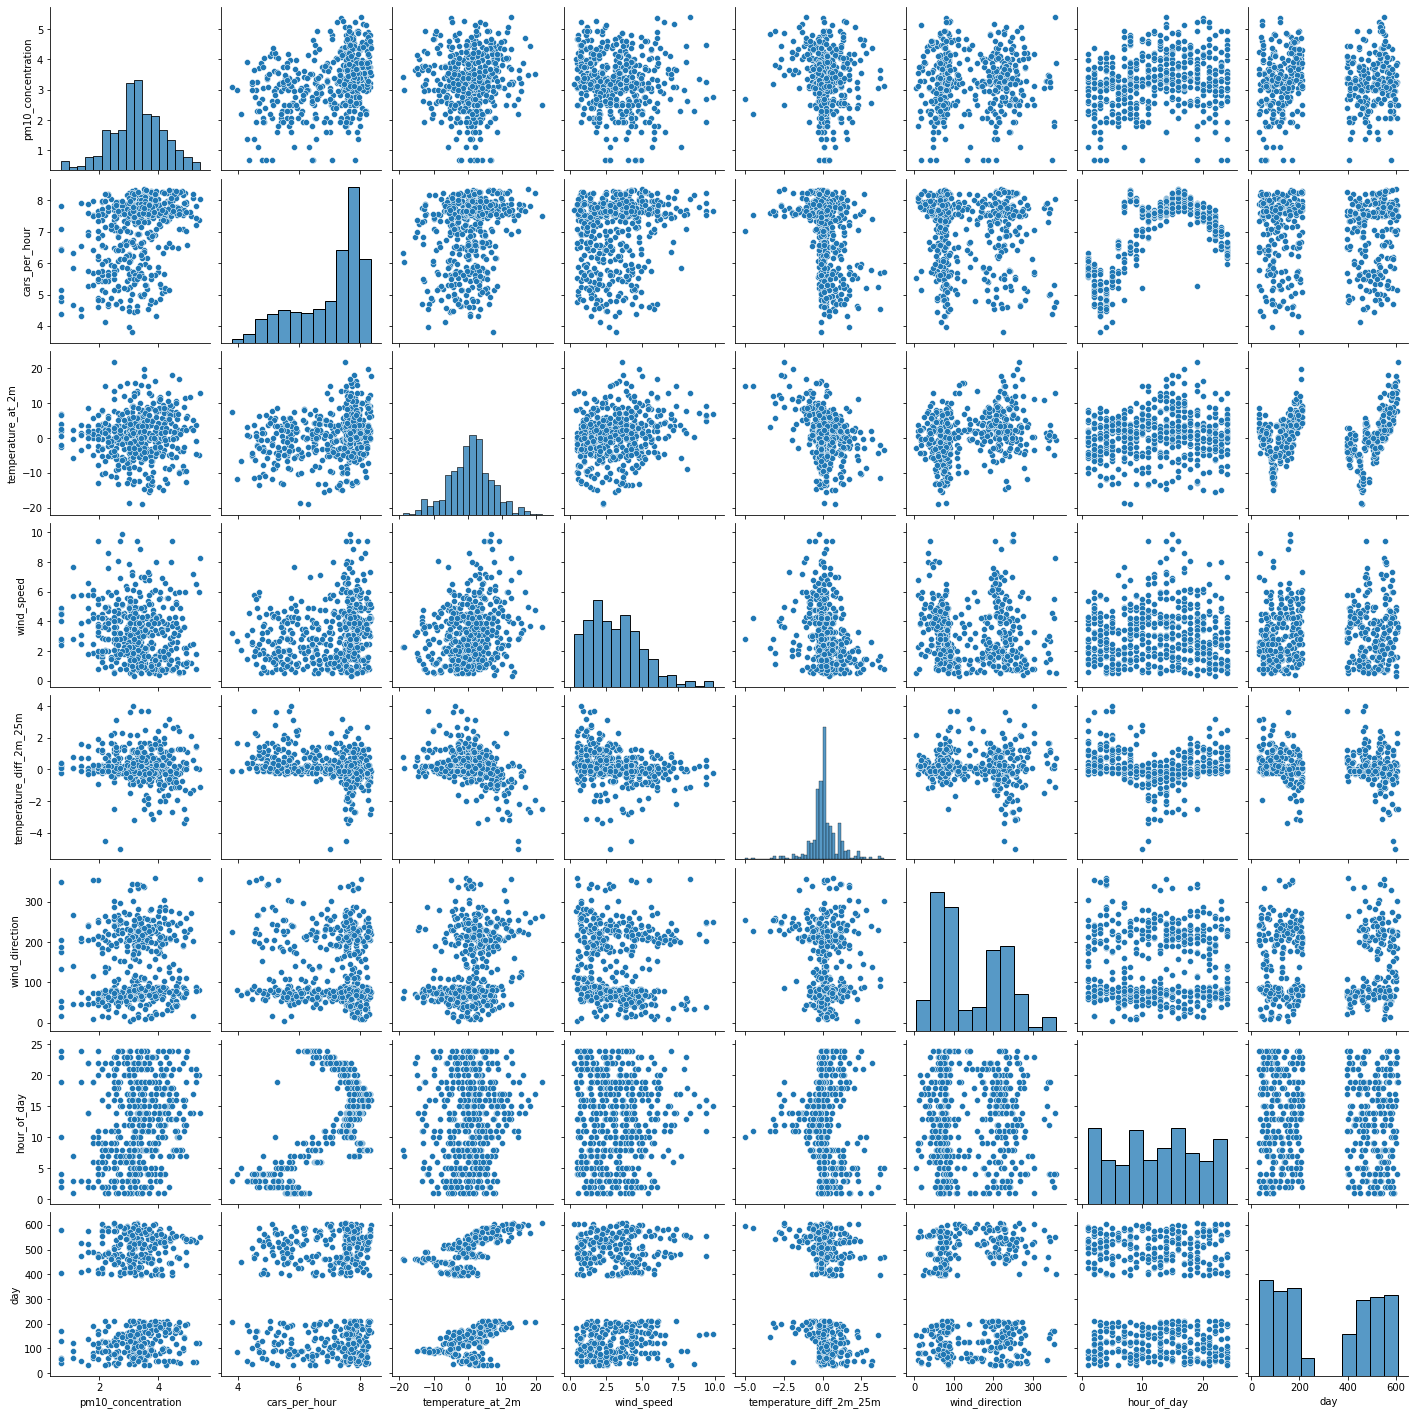

In [7]:
sns.pairplot(df)

After looking at the pairplot, we are pretty set on our features for setting up our untruncated regression. We will set up our untruncated regression with $\textit{cars_per_hour}$ and $\textit{wind_speed}$ as our input features, and $\textit{pm10_concentration}$ as our prediction task. We now look at the ground-truth, and look at some of its metrics.

When we look at the $R^2$ of our original regression, we notice that is not that high $.17$. However, we only need our residuals to be normally distributed for our framework to work.

R^2:  0.1728636862809666
ground-truth variance:  0.6504841446876526


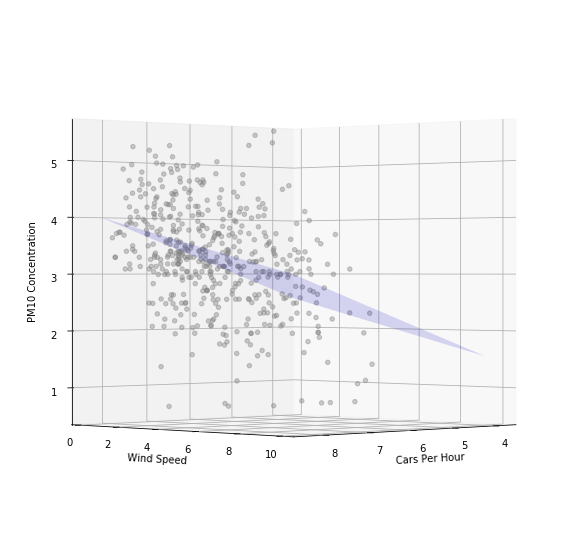

In [65]:
data_df = pd.DataFrame({'cars_per_hour': df['cars_per_hour'], 'wind_speed': df['wind_speed'], 'y': df['pm10_concentration']})
X, y = Tensor(df[['cars_per_hour', 'wind_speed']].to_numpy()), Tensor(df['pm10_concentration'].to_numpy()[...,None])
gt_ols = LinearRegression()
gt_ols.fit(X, y)
score = gt_ols.score(X, y)
print("R^2: ", score)
gt_var = (y - gt_ols.predict(X)).var(0)
print('ground-truth variance: ', float(gt_var))

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

x_max, x_min = X.max(0)[0], X.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], .1)
Y = np.arange(x_min[1], x_max[1], .1)
X_, Y = np.meshgrid(X_, Y) 


actual = Tensor([])
for i in range(X_.shape[0]): 
    input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
    actual = ch.cat([actual, Tensor(gt_ols.predict(input_))], 1)
ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue', label='ground truth')
ax.set_xlabel('Cars Per Hour')
ax.set_ylabel('Wind Speed')
ax.set_zlabel('PM10 Concentration')
ax.scatter3D(X[:,0], X[:,1], y, color='grey', label='S', alpha=.4)
ax.view_init(0, 45)

# Bootstrap Untruncated Linear Regression
Here, we will start by bootstrapping our standard, untruncated linear regression. We will start using parametric resampling.

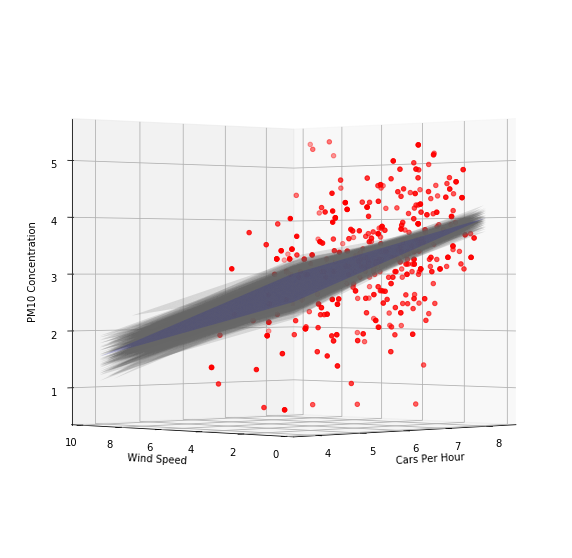

In [112]:
boot_coefs = ch.Tensor([])
boot_interc = ch.Tensor([])

# resample with replacement each row 

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

for _ in range(args.n_boots):
    # sample with replacement from the data dataframe
    sample_df = data_df.sample(n=X.size(0), replace=True)
    # fit a linear regression model 
    ols_model_temp = LinearRegression()
    ols_model_temp.fit(X=sample_df[['cars_per_hour', 'wind_speed']], y=sample_df['y'])
    
    # append coefficients 
    boot_coefs = ch.cat([boot_coefs, ch.Tensor([ols_model_temp.coef_])])
    boot_interc = ch.cat([boot_interc, ch.Tensor([ols_model_temp.intercept_])])
    
    # plot greyed out line 
    data_temp = Tensor(sample_df[['cars_per_hour', 'wind_speed']].to_numpy())
    x_max, x_min = data_temp.max(0)[0], data_temp.min(0)[0]
    x_temp = np.arange(x_min[0], x_max[0], .1)
    y_temp = np.arange(x_min[1], x_max[1], .1)
    x_temp, y_temp = np.meshgrid(x_temp, y_temp) 
    
    actual_temp = Tensor([])
    for i in range(x_temp.shape[0]): 
        input_ = Tensor(np.hstack([x_temp[i].reshape(-1, 1), y_temp[i].reshape(-1, 1)]))
        actual_temp = ch.cat([actual_temp, Tensor(ols_model_temp.predict(input_)).unsqueeze(1)], 1)
        
    ax.plot_surface(x_temp, y_temp, actual_temp.numpy().T, color='grey', alpha=.2, label='bootstrap')
    

ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue', label='no bootstrap')
ax.scatter3D(sample_df['cars_per_hour'], sample_df['wind_speed'], sample_df['y'], color='red')
ax.set_xlabel('Cars Per Hour')
ax.set_ylabel('Wind Speed')
ax.set_zlabel('PM10 Concentration')
ax.view_init(0, 225)

# Plot the Coefficient and the Intercept Distributions
Looking at the distributions of the regression's coefficients and intercept, they seem to follow a normal distribution.

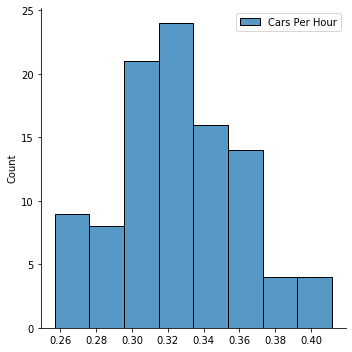

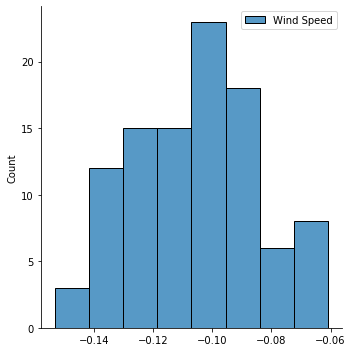

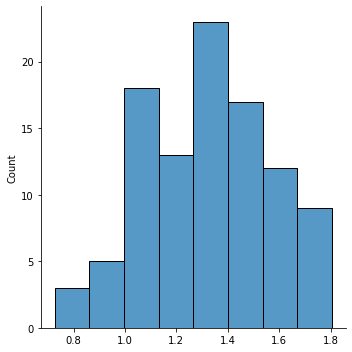

In [128]:
sns.displot(boot_coefs[:,0], label='Cars Per Hour')
plt.legend()
plt.show()
sns.displot(boot_coefs[:,1], label='Wind Speed')
plt.legend()
plt.show()
sns.displot(boot_interc, label='PM10 Concentration')

# Truncate Dataset
We now truncate our dataset, by applying left truncation at some point. Left truncation consists of removing all $(x_{i}, y_{i})$ pairs, whose $y_{i}$ falls below the threshold $C$. We thent truncate our dataset at $C=2.0$. We we truncated we notice that only $92%$ of the original samples survive. We denote this heuristic as the survival probability, and call is $\alpha$. We then plot what the truncation does to our underlying regression. When plotting the new truncated regression, we notice that borth the $R^{2}$ and the empirirical noise variance were biased by the imposed truncation.

alpha:  0.92
r^2:  0.13429628280963535
empirical variance:  0.4788742661476135


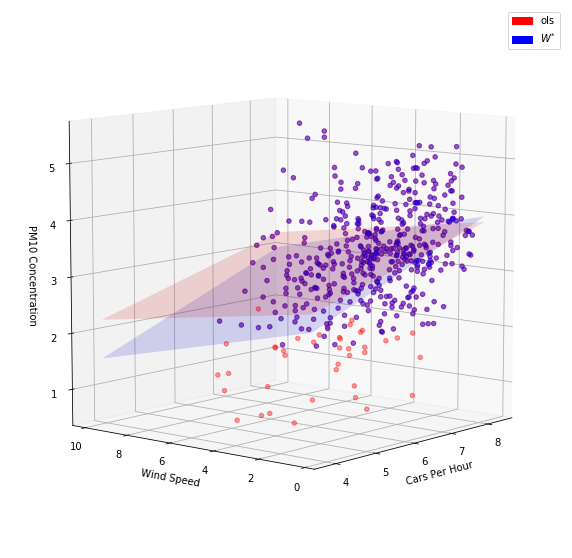

In [131]:
phi = oracle.Left(2.0)
indices = phi(y).flatten().nonzero(as_tuple=False).flatten()
x_trunc, y_trunc = X[indices], y[indices]
alpha = x_trunc.size(0) / X.size(0)
print("alpha: ", alpha)

trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc) 
score = trunc_ols.score(X, y)
print("r^2: ", score)
emp_var = (y_trunc - trunc_ols.predict(x_trunc)).var(0)
print('empirical variance: ', float(emp_var))


fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

x_max, x_min = X.max(0)[0], X.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], .1)
Y = np.arange(x_min[1], x_max[1], .1)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    actual, emp = Tensor([]), Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, Tensor(trunc_ols.predict(input_))], 1)
        actual = ch.cat([actual, Tensor(gt_ols.predict(input_))], 1)

    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
ax.scatter3D(X[:,0], X[:,1], y, color='red', label='entire dataset', alpha=.4)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color='blue', label='S', alpha=.4)

emp_patch = mpatches.Patch(color='red', label='ols')
gt_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[emp_patch, gt_patch], loc="upper right")

ax.set_xlabel('Cars Per Hour')
ax.set_ylabel('Wind Speed')
ax.set_zlabel('PM10 Concentration')
    
ax.view_init(9.0, 220)

# Bootstrap Truncated Regression

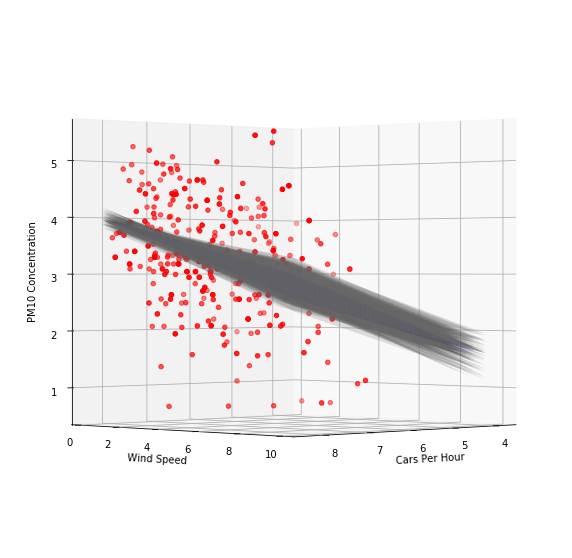

In [139]:
trunc_boot_coefs = ch.Tensor([])
trunc_boot_interc = ch.Tensor([])

# resample with replacement each row 

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

for _ in range(args.n_boots):
    # sample with replacement from the data dataframe
    trunc_sample_df = data_df.sample(n=x_trunc.size(0), replace=True)
    # fit a linear regression model 
    trunc_ols_model_temp = LinearRegression()
    trunc_ols_model_temp.fit(X=trunc_sample_df[['cars_per_hour', 'wind_speed']], y=trunc_sample_df['y'])
    
    # append coefficients 
    trunc_boot_coefs = ch.cat([trunc_boot_coefs, ch.Tensor([trunc_ols_model_temp.coef_])])
    trunc_boot_interc = ch.cat([trunc_boot_interc, ch.Tensor([trunc_ols_model_temp.intercept_])])
    
    # plot greyed out line 
    trunc_data_temp = Tensor(trunc_sample_df[['cars_per_hour', 'wind_speed']].to_numpy())
    x_max, x_min = trunc_data_temp.max(0)[0], trunc_data_temp.min(0)[0]
    x_temp = np.arange(x_min[0], x_max[0], .1)
    y_temp = np.arange(x_min[1], x_max[1], .1)
    x_temp, y_temp = np.meshgrid(x_temp, y_temp) 
    
    actual_temp = Tensor([])
    for i in range(x_temp.shape[0]): 
        input_ = Tensor(np.hstack([x_temp[i].reshape(-1, 1), y_temp[i].reshape(-1, 1)]))
        actual_temp = ch.cat([actual_temp, Tensor(trunc_ols_model_temp.predict(input_)).unsqueeze(1)], 1)
        
    ax.plot_surface(x_temp, y_temp, actual_temp.numpy().T, color='grey', alpha=.2, label='bootstrap')
    

ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue', label='no bootstrap')
ax.scatter3D(trunc_sample_df['cars_per_hour'], trunc_sample_df['wind_speed'], trunc_sample_df['y'], color='red')
ax.set_xlabel('Cars Per Hour')
ax.set_ylabel('Wind Speed')
ax.set_zlabel('PM10 Concentration')
ax.view_init(0, 45)

# Plot the Coefficients and the Intercepts of the Truncated Regression

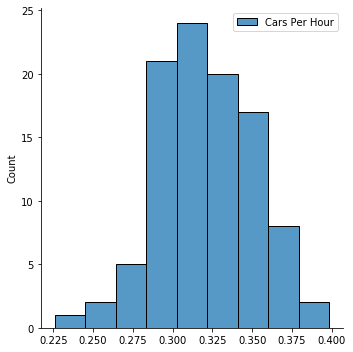

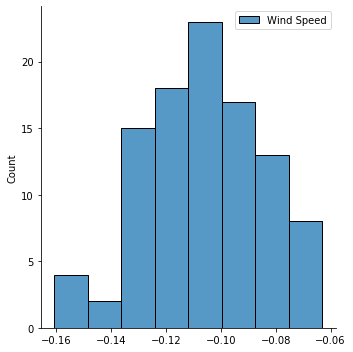

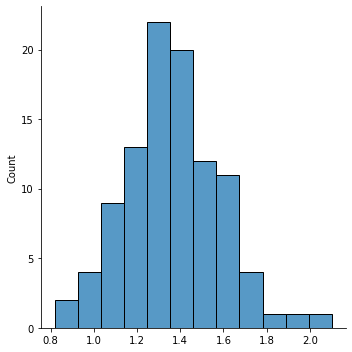

In [140]:
sns.displot(trunc_boot_coefs[:,0], label='Cars Per Hour')
plt.legend()
plt.show()
sns.displot(trunc_boot_coefs[:,1], label='Wind Speed')
plt.legend()
plt.show()
sns.displot(trunc_boot_interc, label='PM10 Concentration')

# Data Preprocessing
Now that we have our truncated dataset, then next thing that we have to do is run run our algorithm on the truncated data, and see if we can relieve some of the bias. Nevertheless, before doing that we want to do some feature engineering. 

First, we want to normalize our input features dataset. So, we divide all of our covariate features by $B\sqrt{k}$, so that $||x_{i}||_{2}^{2} \leq 1$, and reside on the $\ell_{2}$ ball. By doing this, the norm of $w$ will be multiplied by $B\sqrt{k}$.

Next, we want to standardize our dependent variable. We will do this by first substracting the mean of our dependent variable from each our dependent variables, and divide the standard deviation of the empirical noise variance. Our truncated dataset, will now have a dependent variable centered around the origin with a noise variance of 1. 

Since, we standardize our dependent variable, we next have to make sure to update our truncation set using the same standardization technique.

In [141]:
beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
x_trunc_norm = x_trunc / beta
x_norm = X / beta

We will first try to remove bias from the regression assuming that the noise variance of our untruncated dataset is the ground-truth noise variance of the linear regression problem. To do this, we standardize our dependent variable and other truncation set by the noise variance that we receive when we impose no truncation on our dataset. 

NOTE: since we normalize our input features and standardize our dependent variable, we need to make sure that reverse the applied transformation when our procedure is complete. To do this multiply our weight vector and intercept by the untruncated noise variance, we also divide our weight vector by our beta constant, and add the mean our truncated dependet variable to our intercept.

In [142]:
data = ch.linspace(0, 1.5, 100).reshape(-1, 1)

# scale wind by actual noise variance
y_trunc_mu = y_trunc.mean(0)
y_trunc_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(gt_var)
y_scaled = (y - y_trunc_mu) / ch.sqrt(gt_var)

In [184]:
scaled_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(gt_var))
data_df = pd.DataFrame({'cars_per_hour': x_trunc_norm[:,0], 'wind_speed': x_trunc_norm[:,1], 'y': y_trunc_scaled.numpy().flatten()})

known_trunc_coefs = ch.Tensor([])
known_trunc_interc = ch.Tensor([])

for _ in range(args.n_boots):
    # sample with replacement from the data dataframe
    trunc_sample_df = data_df.sample(n=x_trunc.size(0), replace=True)
    
    known_trunc_reg = TruncatedRegression(phi=scaled_phi, alpha=Tensor([alpha]), lr=args.lr, unknown=args.unknown, bs=args.bs, n=args.n, tol=args.tol, steps=args.steps, val=args.n)
    known_trunc_reg.fit(Tensor(trunc_sample_df[['cars_per_hour', 'wind_speed']].to_numpy()), Tensor(trunc_sample_df['y'].to_numpy()).unsqueeze(1))
    known_w, known_w0 = ((known_trunc_reg.weight * ch.sqrt(gt_var))).T / beta, known_trunc_reg.intercept * ch.sqrt(gt_var) + y_trunc_mu
    
    # append coefficients 
    known_trunc_coefs = ch.cat([known_trunc_coefs, known_w])
    known_trunc_interc = ch.cat([known_trunc_interc, known_w0])

Final Score: 0.002567935734987259
Iteration 1 | Score: 0.0861370638012886
Iteration 2 | Score: 0.04541277140378952
Iteration 3 | Score: 0.06789988279342651
Iteration 4 | Score: 0.0761113092303276
Iteration 5 | Score: 0.029340453445911407
Iteration 6 | Score: 0.022535018622875214
Iteration 7 | Score: 0.035976506769657135
Iteration 8 | Score: 0.04683581739664078
Iteration 9 | Score: 0.049814075231552124
Iteration 10 | Score: 0.04653859883546829
Final Score: 0.0015414301306009293
Iteration 1 | Score: 0.0370311364531517
Iteration 2 | Score: 0.05529763922095299
Iteration 3 | Score: 0.07043460011482239
Iteration 4 | Score: 0.10647456347942352
Iteration 5 | Score: 0.10729480534791946
Iteration 6 | Score: 0.04815076291561127
Iteration 7 | Score: 0.10910492390394211
Iteration 8 | Score: 0.0697537288069725
Iteration 9 | Score: 0.0517265722155571
Iteration 10 | Score: 0.04240605980157852
Iteration 11 | Score: 0.040943630039691925
Iteration 12 | Score: 0.08576464653015137
Iteration 13 | Score: 0.0

Iteration 5 | Score: 0.08624385297298431
Iteration 6 | Score: 0.0750507041811943
Iteration 7 | Score: 0.09808377176523209
Iteration 8 | Score: 0.09347885847091675
Iteration 9 | Score: 0.06772860884666443
Iteration 10 | Score: 0.11543340981006622
Iteration 11 | Score: 0.10931983590126038
Iteration 12 | Score: 0.10514552891254425
Iteration 13 | Score: 0.06699826568365097
Iteration 14 | Score: 0.10593925416469574
Iteration 15 | Score: 0.09584008902311325
Iteration 16 | Score: 0.0969439223408699
Iteration 17 | Score: 0.06514894217252731
Iteration 18 | Score: 0.09112515300512314
Iteration 19 | Score: 0.09698644280433655
Iteration 20 | Score: 0.10903536528348923
Iteration 21 | Score: 0.08942709863185883
Iteration 22 | Score: 0.08891073614358902
Iteration 23 | Score: 0.11141860485076904
Iteration 24 | Score: 0.09790609031915665
Iteration 25 | Score: 0.12353212386369705
Iteration 1 | Score: 0.10756020247936249
Iteration 2 | Score: 0.041482239961624146
Iteration 3 | Score: 0.050340715795755386


Iteration 18 | Score: 0.15836811065673828
Iteration 19 | Score: 0.11525584757328033
Iteration 20 | Score: 0.05329028517007828
Iteration 21 | Score: 0.11540866643190384
Iteration 22 | Score: 0.1251833736896515
Iteration 23 | Score: 0.12619853019714355
Iteration 24 | Score: 0.09689375013113022
Iteration 25 | Score: 0.10628999769687653
Iteration 1 | Score: 0.11843519657850266
Iteration 2 | Score: 0.2097366601228714
Iteration 3 | Score: 0.09246574342250824
Iteration 4 | Score: 0.09563737362623215
Iteration 5 | Score: 0.1231769546866417
Iteration 6 | Score: 0.20011016726493835
Iteration 7 | Score: 0.18652041256427765
Iteration 8 | Score: 0.06825808435678482
Iteration 9 | Score: 0.03295403718948364
Iteration 10 | Score: 0.1395936906337738
Iteration 11 | Score: 0.1753937155008316
Iteration 12 | Score: 0.09699741750955582
Iteration 13 | Score: 0.09383805096149445
Iteration 14 | Score: 0.15298216044902802
Iteration 15 | Score: 0.16398294270038605
Iteration 16 | Score: 0.15498743951320648
Iterat

Iteration 9 | Score: 0.14292222261428833
Iteration 10 | Score: 0.055160198360681534
Iteration 11 | Score: 0.1410146802663803
Iteration 12 | Score: 0.14434543251991272
Iteration 13 | Score: 0.15911278128623962
Iteration 14 | Score: 0.0909501165151596
Iteration 15 | Score: 0.18039193749427795
Iteration 16 | Score: 0.14493882656097412
Iteration 17 | Score: 0.18728718161582947
Iteration 18 | Score: 0.12266652286052704
Iteration 19 | Score: 0.057024672627449036
Iteration 20 | Score: 0.14686937630176544
Iteration 21 | Score: 0.1292591392993927
Iteration 22 | Score: 0.12922486662864685
Iteration 23 | Score: 0.09792996197938919
Iteration 24 | Score: 0.17453297972679138
Iteration 25 | Score: 0.15710033476352692
Iteration 1 | Score: 0.06268566846847534
Iteration 2 | Score: 0.13919809460639954
Iteration 3 | Score: 0.18082782626152039
Iteration 4 | Score: 0.05808836594223976
Iteration 5 | Score: 0.02816566824913025
Iteration 6 | Score: 0.08108148723840714
Iteration 7 | Score: 0.14657524228096008
I

Iteration 18 | Score: 0.13504046201705933
Iteration 19 | Score: 0.11134283244609833
Iteration 20 | Score: 0.0909339189529419
Iteration 21 | Score: 0.09797344356775284
Iteration 22 | Score: 0.0898711085319519
Iteration 23 | Score: 0.11505912244319916
Iteration 24 | Score: 0.09372647851705551
Iteration 25 | Score: 0.09609197080135345
Iteration 1 | Score: 0.03480241075158119
Iteration 2 | Score: 0.016833193600177765
Final Score: 0.00734502961859107
Final Score: 0.0008637569844722748
Iteration 1 | Score: 0.14778681099414825
Iteration 2 | Score: 0.08197396248579025
Iteration 3 | Score: 0.06510747969150543
Iteration 4 | Score: 0.07435677200555801
Iteration 5 | Score: 0.11539480835199356
Iteration 6 | Score: 0.10364064574241638
Iteration 7 | Score: 0.0770597755908966
Iteration 8 | Score: 0.0677039697766304
Iteration 9 | Score: 0.04152983799576759
Iteration 10 | Score: 0.12710896134376526
Iteration 11 | Score: 0.08046626299619675
Iteration 12 | Score: 0.06801412254571915
Iteration 13 | Score: 

Iteration 1 | Score: 0.05224761366844177
Iteration 2 | Score: 0.08977831900119781
Final Score: 0.006978532299399376
Iteration 1 | Score: 0.04788549244403839
Iteration 2 | Score: 0.0859769731760025
Iteration 3 | Score: 0.18100345134735107
Iteration 4 | Score: 0.15017187595367432
Iteration 5 | Score: 0.10037155449390411
Iteration 6 | Score: 0.0950746014714241
Iteration 7 | Score: 0.09885203093290329
Iteration 8 | Score: 0.1791958063840866
Iteration 9 | Score: 0.14365693926811218
Iteration 10 | Score: 0.07109701633453369
Iteration 11 | Score: 0.09620451927185059
Iteration 12 | Score: 0.1859261393547058
Iteration 13 | Score: 0.16460704803466797
Iteration 14 | Score: 0.09766789525747299
Iteration 15 | Score: 0.08637425303459167
Iteration 16 | Score: 0.09952635318040848
Iteration 17 | Score: 0.17405469715595245
Iteration 18 | Score: 0.1419062316417694
Iteration 19 | Score: 0.06783076375722885
Iteration 20 | Score: 0.1090131625533104
Iteration 21 | Score: 0.17373886704444885
Iteration 22 | Sc

Iteration 1 | Score: 0.12981583178043365
Iteration 2 | Score: 0.09363536536693573
Iteration 3 | Score: 0.07326985895633698
Iteration 4 | Score: 0.15531504154205322
Iteration 5 | Score: 0.1350937932729721
Iteration 6 | Score: 0.09862812608480453
Iteration 7 | Score: 0.09455825388431549
Iteration 8 | Score: 0.13888955116271973
Iteration 9 | Score: 0.10242445021867752
Iteration 10 | Score: 0.11974386870861053
Iteration 11 | Score: 0.10805658996105194
Iteration 12 | Score: 0.0876651406288147
Iteration 13 | Score: 0.12952479720115662
Iteration 14 | Score: 0.12140900641679764
Iteration 15 | Score: 0.10122814774513245
Iteration 16 | Score: 0.1117720752954483
Iteration 17 | Score: 0.12274310737848282
Iteration 18 | Score: 0.09940023720264435
Iteration 19 | Score: 0.11086846143007278
Iteration 20 | Score: 0.11777631938457489
Iteration 21 | Score: 0.10986146330833435
Iteration 22 | Score: 0.13157083094120026
Iteration 23 | Score: 0.12630192935466766
Iteration 24 | Score: 0.11738963425159454
Iter

Iteration 23 | Score: 0.10849324613809586
Iteration 24 | Score: 0.11727043986320496
Iteration 25 | Score: 0.12060464173555374
Iteration 1 | Score: 0.014383532106876373
Iteration 2 | Score: 0.020388472825288773
Iteration 3 | Score: 0.04208819195628166
Iteration 4 | Score: 0.029118776321411133
Iteration 5 | Score: 0.02753356099128723
Iteration 6 | Score: 0.037259817123413086
Iteration 7 | Score: 0.0629308894276619
Iteration 8 | Score: 0.022296849638223648
Iteration 9 | Score: 0.027044884860515594
Final Score: 0.002924960106611252
Iteration 1 | Score: 0.09901255369186401
Iteration 2 | Score: 0.16944840550422668
Iteration 3 | Score: 0.09751544892787933
Iteration 4 | Score: 0.144297257065773
Iteration 5 | Score: 0.12505587935447693
Iteration 6 | Score: 0.14631445705890656
Iteration 7 | Score: 0.17284312844276428
Iteration 8 | Score: 0.13372090458869934
Iteration 9 | Score: 0.12990012764930725
Iteration 10 | Score: 0.10999352484941483
Iteration 11 | Score: 0.14346952736377716
Iteration 12 | 

Iteration 8 | Score: 0.06262288987636566
Iteration 9 | Score: 0.1437429040670395
Iteration 10 | Score: 0.12343571335077286
Iteration 11 | Score: 0.09953102469444275
Iteration 12 | Score: 0.08892811834812164
Iteration 13 | Score: 0.11215486377477646
Iteration 14 | Score: 0.1363181471824646
Iteration 15 | Score: 0.10746882855892181
Iteration 16 | Score: 0.10256139934062958
Iteration 17 | Score: 0.08867349475622177
Iteration 18 | Score: 0.14355061948299408
Iteration 19 | Score: 0.11014609783887863
Iteration 20 | Score: 0.09595523774623871
Iteration 21 | Score: 0.11478902399539948
Iteration 22 | Score: 0.09844723343849182
Iteration 23 | Score: 0.0978851318359375
Iteration 24 | Score: 0.1127203106880188
Iteration 25 | Score: 0.10681311041116714
Iteration 1 | Score: 0.11458206176757812
Iteration 2 | Score: 0.03761424124240875
Iteration 3 | Score: 0.043782658874988556
Iteration 4 | Score: 0.02398751676082611
Iteration 5 | Score: 0.07986868917942047
Iteration 6 | Score: 0.09393271803855896
Ite

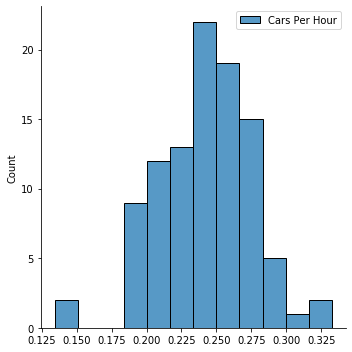

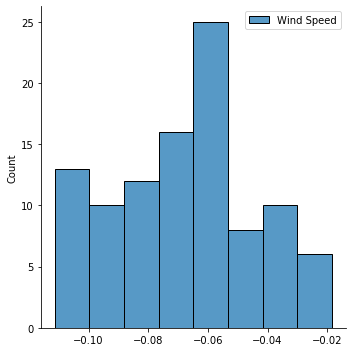

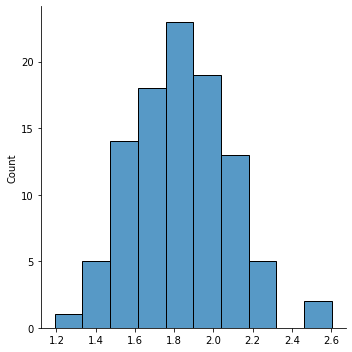

In [185]:
sns.displot(known_trunc_coefs[:,0], label='Cars Per Hour')
plt.legend()
plt.show()
sns.displot(known_trunc_coefs[:,1], label='Wind Speed')
plt.legend()
plt.show()
sns.displot(known_trunc_interc, label='Intercept')

In [186]:
known_w = known_trunc_coefs.mean(0).unsqueeze(1)
known_w0 = known_trunc_interc.mean(0)

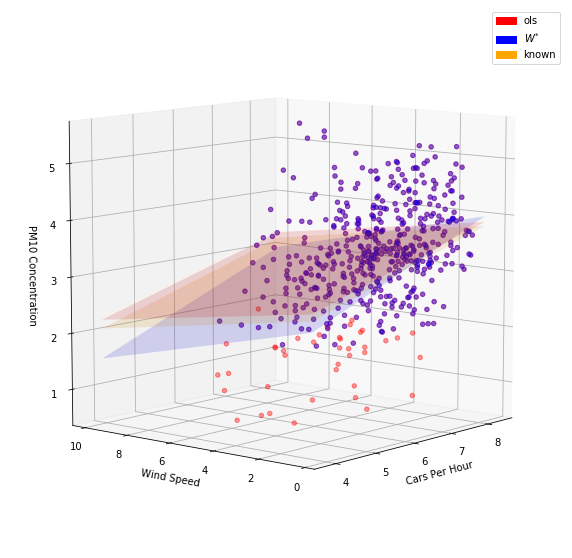

In [187]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

with ch.no_grad():
    known_pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        known_pred = ch.cat([known_pred, input_@known_w + known_w0], 1)

    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    ax.plot_surface(X_, Y, known_pred.numpy().T, alpha=.15, color='orange')

ax.scatter3D(X[:,0], X[:,1], y, color='red', label='entire dataset', alpha=.4)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color='blue', label='S', alpha=.4)
    
red_patch = mpatches.Patch(color='red', label='ols')

known_patch = mpatches.Patch(color='orange', label='known')
plt.legend(handles=[emp_patch, gt_patch, known_patch], loc="upper right")

ax.set_xlabel('Cars Per Hour')
ax.set_ylabel('Wind Speed')
ax.set_zlabel('PM10 Concentration')
    
ax.view_init(9.0, 220)

Now, we will try to remove bias from the regression without assuming that we know the noise variance. To do this, we standardize our dependent variable and other truncation set by the noise variance that we receive when we impose truncation on our dataset. We apply the same transformations to our dataset, as we do in the known variance case, but with a differnt standard deviation.

In [162]:
data = ch.linspace(0, 1.5, 100).reshape(-1, 1)

# scale wind by actual noise variance
y_trunc_mu = y_trunc.mean(0)
y_trunc_emp_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(emp_var)
data_df = pd.DataFrame({'cars_per_hour': x_trunc_norm[:,0], 'wind_speed': x_trunc_norm[:,1], 'y': y_trunc_emp_scaled.numpy().flatten()})

y_emp_scaled = (y - y_trunc_mu) / ch.sqrt(emp_var)

In [191]:
emp_scaled_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(emp_var))
data_df = pd.DataFrame({'cars_per_hour': x_trunc_norm[:,0], 'wind_speed': x_trunc_norm[:,1], 'y': y_trunc_emp_scaled.numpy().flatten()})

unknown_trunc_coefs = ch.Tensor([])
unknown_trunc_interc = ch.Tensor([])

for _ in range(args.n_boots):
    # sample with replacement from the data dataframe
    trunc_sample_df = data_df.sample(n=x_trunc.size(0), replace=True)
    unknown_trunc_reg = TruncatedRegression(phi=emp_scaled_phi, alpha=Tensor([alpha]), unknown=True, lr=args.lr, step_lr_gamma=args.step_lr_gamma, bs=args.bs, n=args.n, tol=args.tol, steps=args.steps, val=args.n)

    
    unknown_trunc_reg.fit(Tensor(trunc_sample_df[['cars_per_hour', 'wind_speed']].to_numpy()), Tensor(trunc_sample_df['y'].to_numpy()).unsqueeze(1))
    unknown_w, unknown_w0 = ((unknown_trunc_reg.weight * ch.sqrt(emp_var))).T / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_var) + y_trunc_mu
    
    # append coefficients 
    unknown_trunc_coefs = ch.cat([unknown_trunc_coefs, unknown_w])
    unknown_trunc_interc = ch.cat([unknown_trunc_interc, unknown_w0])

Iteration 1 | Score: 0.013351854868233204
Iteration 2 | Score: 0.029951386153697968
Iteration 3 | Score: 0.07069843262434006
Iteration 4 | Score: 0.024197036400437355
Iteration 5 | Score: 0.030771905556321144
Iteration 6 | Score: 0.05477648973464966
Iteration 7 | Score: 0.030073178932070732
Iteration 8 | Score: 0.03393878415226936
Iteration 9 | Score: 0.05126349627971649
Iteration 10 | Score: 0.024744030088186264
Iteration 11 | Score: 0.03007693774998188
Iteration 12 | Score: 0.034023553133010864
Iteration 13 | Score: 0.02391473576426506
Iteration 14 | Score: 0.022345516830682755
Iteration 15 | Score: 0.017796089872717857
Iteration 16 | Score: 0.014885840937495232
Iteration 17 | Score: 0.0427548810839653
Iteration 18 | Score: 0.035432327538728714
Iteration 19 | Score: 0.0211124699562788
Iteration 20 | Score: 0.0516146719455719
Iteration 21 | Score: 0.022959614172577858
Iteration 22 | Score: 0.03208823502063751
Iteration 23 | Score: 0.025917617604136467
Iteration 24 | Score: 0.038844902

Iteration 21 | Score: 0.12936003506183624
Iteration 22 | Score: 0.12347127497196198
Iteration 23 | Score: 0.10774118453264236
Iteration 24 | Score: 0.12407571077346802
Iteration 25 | Score: 0.10685162991285324
Iteration 1 | Score: 0.09701994806528091
Iteration 2 | Score: 0.04521053656935692
Iteration 3 | Score: 0.023340143263339996
Iteration 4 | Score: 0.03601823002099991
Iteration 5 | Score: 0.031164932996034622
Iteration 6 | Score: 0.06242853403091431
Iteration 7 | Score: 0.06931440532207489
Iteration 8 | Score: 0.04184763506054878
Iteration 9 | Score: 0.030344799160957336
Iteration 10 | Score: 0.03470256179571152
Iteration 11 | Score: 0.04377523437142372
Iteration 12 | Score: 0.019628219306468964
Final Score: 0.0009034787071868777
Iteration 1 | Score: 0.11802275478839874
Iteration 2 | Score: 0.07114580273628235
Iteration 3 | Score: 0.06241563707590103
Iteration 4 | Score: 0.10706962645053864
Iteration 5 | Score: 0.12281768023967743
Iteration 6 | Score: 0.10461362451314926
Iteration 

Iteration 6 | Score: 0.08032627403736115
Iteration 7 | Score: 0.23142829537391663
Iteration 8 | Score: 0.10311060398817062
Iteration 9 | Score: 0.14735962450504303
Iteration 10 | Score: 0.07928415387868881
Iteration 11 | Score: 0.14621810615062714
Iteration 12 | Score: 0.17571258544921875
Iteration 13 | Score: 0.219730943441391
Iteration 14 | Score: 0.11772579699754715
Iteration 15 | Score: 0.06448045372962952
Iteration 16 | Score: 0.22661331295967102
Iteration 17 | Score: 0.10674530267715454
Iteration 18 | Score: 0.13253404200077057
Iteration 19 | Score: 0.10755430907011032
Iteration 20 | Score: 0.16232411563396454
Iteration 21 | Score: 0.20447847247123718
Iteration 22 | Score: 0.2057259976863861
Iteration 23 | Score: 0.13952885568141937
Iteration 24 | Score: 0.09147860109806061
Iteration 25 | Score: 0.18624936044216156
Iteration 1 | Score: 0.09322997182607651
Final Score: 0.009186631068587303
Iteration 1 | Score: 0.1642821878194809
Iteration 2 | Score: 0.11043698340654373
Iteration 3

Iteration 2 | Score: 0.15869911015033722
Iteration 3 | Score: 0.10052568465471268
Iteration 4 | Score: 0.11707747727632523
Iteration 5 | Score: 0.12198726087808609
Iteration 6 | Score: 0.14174848794937134
Iteration 7 | Score: 0.12574318051338196
Iteration 8 | Score: 0.08163034915924072
Iteration 9 | Score: 0.11491457372903824
Iteration 10 | Score: 0.13559789955615997
Iteration 11 | Score: 0.13336792588233948
Iteration 12 | Score: 0.11413125693798065
Iteration 13 | Score: 0.12761062383651733
Iteration 14 | Score: 0.11668349802494049
Iteration 15 | Score: 0.12622618675231934
Iteration 16 | Score: 0.11661425977945328
Iteration 17 | Score: 0.12117842584848404
Iteration 18 | Score: 0.12518310546875
Iteration 19 | Score: 0.1304808259010315
Iteration 20 | Score: 0.12483054399490356
Iteration 21 | Score: 0.12148002535104752
Iteration 22 | Score: 0.11071450263261795
Iteration 23 | Score: 0.1129305362701416
Iteration 24 | Score: 0.11655817180871964
Iteration 25 | Score: 0.11694929003715515
Itera

Iteration 12 | Score: 0.27825796604156494
Iteration 13 | Score: 0.022689878940582275
Iteration 14 | Score: 0.11865971982479095
Iteration 15 | Score: 0.12192098051309586
Iteration 16 | Score: 0.1404494345188141
Iteration 17 | Score: 0.11565054208040237
Iteration 18 | Score: 0.0751471146941185
Iteration 19 | Score: 0.17557388544082642
Iteration 20 | Score: 0.2112039476633072
Iteration 21 | Score: 0.2827248275279999
Iteration 22 | Score: 0.02052953839302063
Iteration 23 | Score: 0.11802081763744354
Iteration 24 | Score: 0.16803893446922302
Iteration 25 | Score: 0.14787662029266357
Iteration 1 | Score: 0.27066299319267273
Iteration 2 | Score: 0.3202638328075409
Iteration 3 | Score: 0.2618331015110016
Iteration 4 | Score: 0.2659808099269867
Iteration 5 | Score: 0.27347275614738464
Iteration 6 | Score: 0.3208993673324585
Iteration 7 | Score: 0.26782408356666565
Iteration 8 | Score: 0.32146549224853516
Iteration 9 | Score: 0.3403201103210449
Iteration 10 | Score: 0.28161415457725525
Iteration

Iteration 18 | Score: 0.07688725739717484
Iteration 19 | Score: 0.08078139275312424
Iteration 20 | Score: 0.06387347728013992
Iteration 21 | Score: 0.0791073739528656
Iteration 22 | Score: 0.09573149681091309
Iteration 23 | Score: 0.054616525769233704
Iteration 24 | Score: 0.06594070792198181
Iteration 25 | Score: 0.06698290258646011
Iteration 1 | Score: 0.15942516922950745
Iteration 2 | Score: 0.16396155953407288
Iteration 3 | Score: 0.12207745015621185
Iteration 4 | Score: 0.12160128355026245
Iteration 5 | Score: 0.16047246754169464
Iteration 6 | Score: 0.14817239344120026
Iteration 7 | Score: 0.09231926500797272
Iteration 8 | Score: 0.11772254854440689
Iteration 9 | Score: 0.15714624524116516
Iteration 10 | Score: 0.13398832082748413
Iteration 11 | Score: 0.14484135806560516
Iteration 12 | Score: 0.11269792169332504
Iteration 13 | Score: 0.11825317144393921
Iteration 14 | Score: 0.1431484967470169
Iteration 15 | Score: 0.13827697932720184
Iteration 16 | Score: 0.1107507050037384
Ite

Iteration 16 | Score: 0.09167500585317612
Iteration 17 | Score: 0.1397779881954193
Iteration 18 | Score: 0.18380604684352875
Iteration 19 | Score: 0.06116504594683647
Iteration 20 | Score: 0.10433411598205566
Iteration 21 | Score: 0.07303954660892487
Iteration 22 | Score: 0.23929712176322937
Iteration 23 | Score: 0.09376442432403564
Iteration 24 | Score: 0.09009567648172379
Iteration 25 | Score: 0.1027040183544159
Iteration 1 | Score: 0.09564972668886185
Iteration 2 | Score: 0.16776172816753387
Iteration 3 | Score: 0.2356918305158615
Iteration 4 | Score: 0.23174333572387695
Iteration 5 | Score: 0.15651129186153412
Iteration 6 | Score: 0.23985126614570618
Iteration 7 | Score: 0.2256622612476349
Iteration 8 | Score: 0.28050103783607483
Iteration 9 | Score: 0.1585531383752823
Iteration 10 | Score: 0.0904824510216713
Iteration 11 | Score: 0.17588742077350616
Iteration 12 | Score: 0.26841938495635986
Iteration 13 | Score: 0.2369043529033661
Iteration 14 | Score: 0.17712511122226715
Iteratio

Iteration 1 | Score: 0.07559556514024734
Iteration 2 | Score: 0.04734216257929802
Iteration 3 | Score: 0.06163208559155464
Iteration 4 | Score: 0.07149795442819595
Iteration 5 | Score: 0.062119197100400925
Iteration 6 | Score: 0.09539991617202759
Iteration 7 | Score: 0.0549149289727211
Iteration 8 | Score: 0.05364655703306198
Iteration 9 | Score: 0.06359661370515823
Iteration 10 | Score: 0.06444752961397171
Iteration 11 | Score: 0.05858813598752022
Iteration 12 | Score: 0.0762830451130867
Iteration 13 | Score: 0.06813903152942657
Iteration 14 | Score: 0.05727763846516609
Iteration 15 | Score: 0.056357625871896744
Iteration 16 | Score: 0.0527692511677742
Iteration 17 | Score: 0.048462558537721634
Iteration 18 | Score: 0.055714286863803864
Iteration 19 | Score: 0.04588307440280914
Iteration 20 | Score: 0.05465319752693176
Iteration 21 | Score: 0.04846888780593872
Iteration 22 | Score: 0.04758844152092934
Iteration 23 | Score: 0.050844769924879074
Iteration 24 | Score: 0.0601024404168129


Iteration 24 | Score: 0.10577468574047089
Iteration 25 | Score: 0.09214786440134048
Iteration 1 | Score: 0.24000392854213715
Iteration 2 | Score: 0.13966725766658783
Iteration 3 | Score: 0.35638105869293213
Iteration 4 | Score: 0.24387244880199432
Iteration 5 | Score: 0.23254534602165222
Iteration 6 | Score: 0.19892176985740662
Iteration 7 | Score: 0.20530487596988678
Iteration 8 | Score: 0.28723064064979553
Iteration 9 | Score: 0.21763145923614502
Iteration 10 | Score: 0.21134938299655914
Iteration 11 | Score: 0.12344352900981903
Iteration 12 | Score: 0.3254065215587616
Iteration 13 | Score: 0.25143346190452576
Iteration 14 | Score: 0.22087068855762482
Iteration 15 | Score: 0.19176499545574188
Iteration 16 | Score: 0.22037696838378906
Iteration 17 | Score: 0.2739211320877075
Iteration 18 | Score: 0.2744741439819336
Iteration 19 | Score: 0.2110975831747055
Iteration 20 | Score: 0.19942426681518555
Iteration 21 | Score: 0.2998087406158447
Iteration 22 | Score: 0.24919305741786957
Iterat

Iteration 24 | Score: 0.14401380717754364
Iteration 25 | Score: 0.10511951893568039
Iteration 1 | Score: 0.10340475291013718
Iteration 2 | Score: 0.08662496507167816
Iteration 3 | Score: 0.07640495896339417
Iteration 4 | Score: 0.06028119847178459
Iteration 5 | Score: 0.07866359502077103
Iteration 6 | Score: 0.09326793253421783
Iteration 7 | Score: 0.09056592732667923
Iteration 8 | Score: 0.07198800891637802
Iteration 9 | Score: 0.0771479606628418
Iteration 10 | Score: 0.06870338320732117
Iteration 11 | Score: 0.07116170227527618
Iteration 12 | Score: 0.05693196877837181
Iteration 13 | Score: 0.06616520881652832
Iteration 14 | Score: 0.07051411271095276
Iteration 15 | Score: 0.05743792653083801
Iteration 16 | Score: 0.06390786170959473
Iteration 17 | Score: 0.07264989614486694
Iteration 18 | Score: 0.07376880943775177
Iteration 19 | Score: 0.06300783902406693
Iteration 20 | Score: 0.0717712938785553
Iteration 21 | Score: 0.05139417201280594
Iteration 22 | Score: 0.07002177089452744
Ite

Iteration 22 | Score: 0.3102591037750244
Iteration 23 | Score: 0.3287925720214844
Iteration 24 | Score: 0.3005082905292511
Iteration 25 | Score: 0.3051677644252777
Iteration 1 | Score: 0.033156394958496094
Iteration 2 | Score: 0.16954806447029114
Iteration 3 | Score: 0.17874714732170105
Iteration 4 | Score: 0.021978287026286125
Iteration 5 | Score: 0.05402094125747681
Iteration 6 | Score: 0.19380614161491394
Iteration 7 | Score: 0.1464861035346985
Iteration 8 | Score: 0.0608283169567585
Iteration 9 | Score: 0.06195079907774925
Iteration 10 | Score: 0.05100350081920624
Iteration 11 | Score: 0.16763877868652344
Iteration 12 | Score: 0.16593804955482483
Iteration 13 | Score: 0.04100450128316879
Iteration 14 | Score: 0.04031319543719292
Iteration 15 | Score: 0.16476808488368988
Iteration 16 | Score: 0.16363239288330078
Iteration 17 | Score: 0.057884689420461655
Iteration 18 | Score: 0.06757694482803345
Iteration 19 | Score: 0.0516020767390728
Iteration 20 | Score: 0.14575384557247162
Itera

Iteration 19 | Score: 0.11745317280292511
Iteration 20 | Score: 0.1037733182311058
Iteration 21 | Score: 0.11359881609678268
Iteration 22 | Score: 0.09557924419641495
Iteration 23 | Score: 0.08906406909227371
Iteration 24 | Score: 0.0932033434510231
Iteration 25 | Score: 0.10277684032917023
Iteration 1 | Score: 0.13537029922008514
Iteration 2 | Score: 0.1361316591501236
Iteration 3 | Score: 0.14046359062194824
Iteration 4 | Score: 0.146540567278862
Iteration 5 | Score: 0.15141580998897552
Iteration 6 | Score: 0.14636702835559845
Iteration 7 | Score: 0.15422427654266357
Iteration 8 | Score: 0.13062533736228943
Iteration 9 | Score: 0.12829625606536865
Iteration 10 | Score: 0.1433091014623642
Iteration 11 | Score: 0.14425671100616455
Iteration 12 | Score: 0.13554798066616058
Iteration 13 | Score: 0.13419876992702484
Iteration 14 | Score: 0.13448093831539154
Iteration 15 | Score: 0.12853431701660156
Iteration 16 | Score: 0.12725046277046204
Iteration 17 | Score: 0.12205437570810318
Iterati

Iteration 17 | Score: 0.06461773067712784
Iteration 18 | Score: 0.07699272036552429
Iteration 19 | Score: 0.08377370983362198
Iteration 20 | Score: 0.061806291341781616
Iteration 21 | Score: 0.06362872570753098
Iteration 22 | Score: 0.046178556978702545
Iteration 23 | Score: 0.08509474992752075
Iteration 24 | Score: 0.06656359881162643
Iteration 25 | Score: 0.06944705545902252


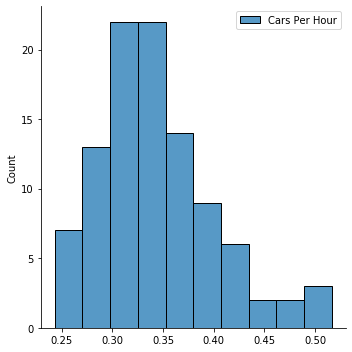

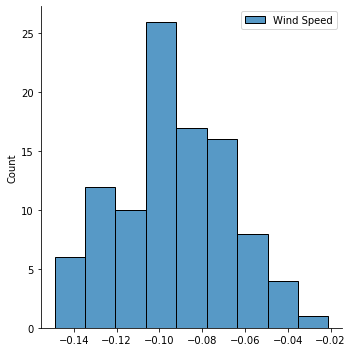

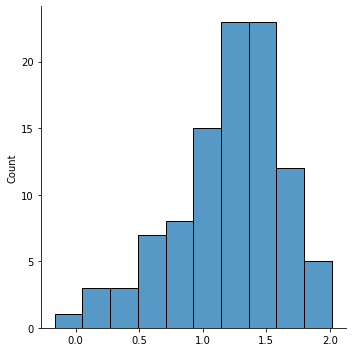

In [198]:
sns.displot(unknown_trunc_coefs[:,0], label='Cars Per Hour')
plt.legend()
plt.show()
sns.displot(unknown_trunc_coefs[:,1], label='Wind Speed')
plt.legend()
plt.show()
sns.displot(unknown_trunc_interc.flatten(), label='Intercept')

In [202]:
w_ = unknown_trunc_coefs.mean(0).unsqueeze(1)
w0_ = unknown_trunc_interc.mean(0)

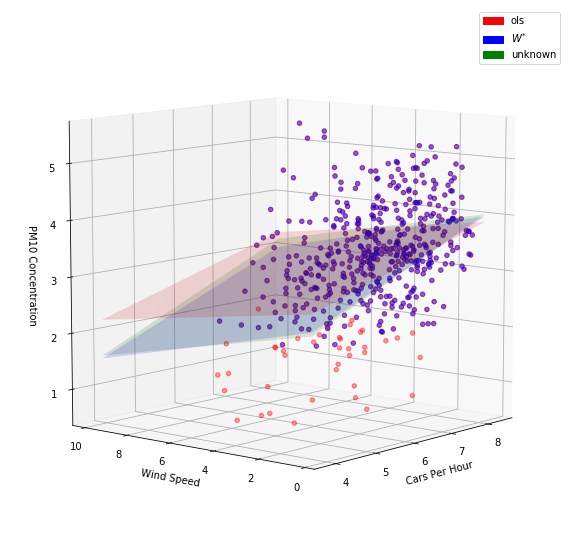

In [204]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

with ch.no_grad():
    unknown_pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        unknown_pred = ch.cat([unknown_pred, input_@w_ + w0_], 1)

    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    ax.plot_surface(X_, Y, unknown_pred.numpy().T, alpha=.15, color='green')

ax.scatter3D(X[:,0], X[:,1], y, color='red', label='entire dataset', alpha=.4)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color='blue', label='S', alpha=.4)
    
unknown_patch = mpatches.Patch(color='green', label='unknown')
plt.legend(handles=[emp_patch, gt_patch, unknown_patch], loc="upper right")

ax.set_xlabel('Cars Per Hour')
ax.set_ylabel('Wind Speed')
ax.set_zlabel('PM10 Concentration')
    
ax.view_init(9.0, 220)

In [206]:
unknown_params = ch.cat([w_.flatten(), w0_]).flatten()
gt_params = Tensor(np.concatenate([gt_ols.coef_.flatten(), gt_ols.intercept_]))
trunc_ols_params = Tensor(np.concatenate([trunc_ols.coef_.flatten(), trunc_ols.intercept_]))
known_params = ch.cat([known_w.flatten(), known_w0.flatten()])

We now spawn a subprocess and run the same regression on truncreg.

In [246]:
data_df = pd.DataFrame({'cars_per_hour': x_trunc[:,0], 'wind_speed': x_trunc[:,1], 'y': y_trunc.numpy().flatten()})

truncreg_coefs = ch.Tensor([])
truncreg_interc = ch.Tensor([])

for _ in range(args.n_boots):
    # sample with replacement from the data dataframe
    trunc_sample_df = data_df.sample(n=x_trunc.size(0), replace=True)
    
    # spawn subprocess to run truncreg experiment
    concat = ch.cat([Tensor(trunc_sample_df[['cars_per_hour', 'wind_speed']].to_numpy()), Tensor(trunc_sample_df['y'].to_numpy()).unsqueeze(1)], dim=1).numpy()

    if not os.path.isdir(args.out_dir): 
        os.mkdir(args.out_dir)
    """
    DATA FORMAT:
        -First n-1 columns are independent variables
        -nth column is dependent variable
    """
    concat_df = pd.DataFrame(concat)
    concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
    """
    Arguments
    - c - truncation point (float)
    - dir - left or right -> type of truncation (str)
    """
    cmd = [COMMAND, PATH2SCRIPT] + [str(phi.left), str(x_trunc.size(1)), 'left', args.out_dir]

    # check_output will run the command and store the result
    st = datetime.datetime.now()
    result = subprocess.check_output(cmd, universal_newlines=True)
    trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
    truncreg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

    truncreg_pred = X@truncreg_params[:-1] + truncreg_params[-1]
        
    # append coefficients 
    truncreg_coefs = ch.cat([truncreg_coefs, truncreg_params[:-1].unsqueeze(0)])
    truncreg_interc = ch.cat([truncreg_interc, truncreg_params[-1].unsqueeze(0)])

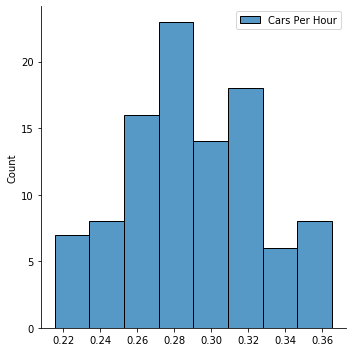

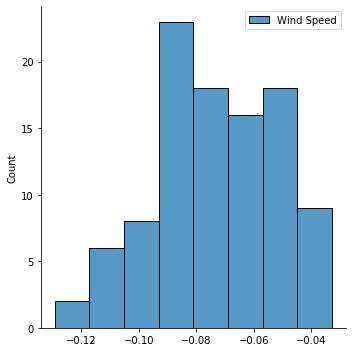

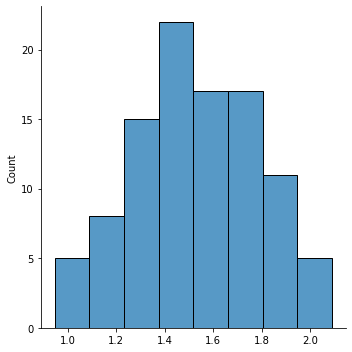

In [247]:
sns.displot(truncreg_coefs[:,0], label='Cars Per Hour')
plt.legend()
plt.show()
sns.displot(truncreg_coefs[:,1], label='Wind Speed')
plt.legend()
plt.show()
sns.displot(truncreg_interc.flatten(), label='Intercept')

In [248]:
truncreg_coef = truncreg_coefs.mean(0)
truncreg_interc = truncreg_interc.mean(0)

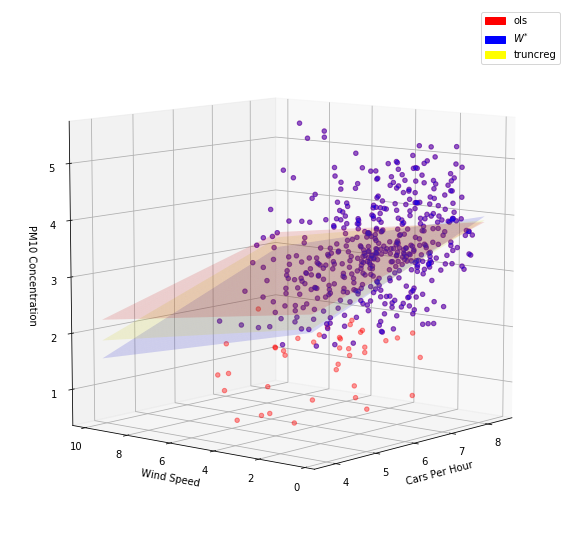

In [249]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

with ch.no_grad():
    truncreg_pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        truncreg_pred = ch.cat([truncreg_pred, (input_@trunc_reg_params[:-1] + trunc_reg_params[-1])[...,None]], 1)

    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    ax.plot_surface(X_, Y, truncreg_pred.numpy().T, alpha=.15, color='yellow')

ax.scatter3D(X[:,0], X[:,1], y, color='red', label='entire dataset', alpha=.4)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color='blue', label='S', alpha=.4)
    
truncreg_patch = mpatches.Patch(color='yellow', label='truncreg')
plt.legend(handles=[emp_patch, gt_patch, truncreg_patch], loc="upper right")

ax.set_xlabel('Cars Per Hour')
ax.set_ylabel('Wind Speed')
ax.set_zlabel('PM10 Concentration')
    
ax.view_init(9.0, 220)

We now plot all of the estimates on the figure to see how the various estimation techniques compare. We show that all three techniques removes bias from the original biased OLS estiamtes. 

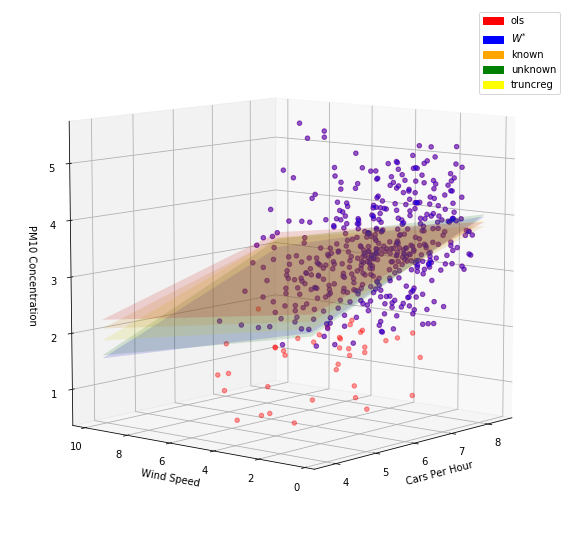

In [250]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
ax.plot_surface(X_, Y, truncreg_pred.numpy().T, alpha=.15, color='yellow')
ax.plot_surface(X_, Y, unknown_pred.numpy().T, alpha=.15, color='green')
ax.plot_surface(X_, Y, known_pred.numpy().T, alpha=.15, color='orange')

ax.scatter3D(X[:,0], X[:,1], y, color='red', label='entire dataset', alpha=.4)
ax.scatter3D(x_trunc[:,0], x_trunc[:,1], y_trunc, color='blue', label='S', alpha=.4)
    

plt.legend(handles=[emp_patch, gt_patch, known_patch, unknown_patch, truncreg_patch], loc="upper right")

ax.set_xlabel('Cars Per Hour')
ax.set_ylabel('Wind Speed')
ax.set_zlabel('PM10 Concentration')
    
ax.view_init(9.0, 220)

# Create Store for Experiment Results

In [251]:
def run_trial(kwargs, X, y, tol, attempts):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > tol) and attempt < attempts:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time   

# Run Procedure
Now, we will run 20 trials of trying to retrieve the underlying untruncaed regression on the regression task presented above.

In [ ]:
# ground_truth parameters
gt = LinearRegression() 
gt.fit(X, y)
gt_params = Tensor(np.concatenate([gt.coef_.flatten() ,gt.intercept_]))
gt_var = Tensor(np.var(gt.predict(X) - y.numpy(), 0))

# variables for tracking best and worst trials

C = [1, 1.5, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 4.0]

# create store
store = Store(args.out_dir + '/' + args.exp)
store.add_table(TABLE_NAME, { 
    'known_r2': float,
    'known_param_mse': float,
    'known_time': int,
    'unknown_param_mse': float,
    'unknown_var_l1': float,
    'unknown_r2': float,
    'unknown_time': int,
    'ols_r2': float, 
    'ols_param_mse': float,
    'ols_var_l1': float,
    'trunc_reg_param_mse': float, 
    'trunc_reg_var_l1': float,
    'trunc_reg_r2': float,
    'trunc_reg_time': int,
    'alpha': float, 
    'c': float, 
    'num_samples': int,
})

for c in C: 
    # truncate
    phi = oracle.Left(c)
    indices = phi(y).flatten().nonzero(as_tuple=False).flatten()
    # bootstrap
    x_trunc, y_trunc = X[indices], y[indices]
    # randomize order
    randperm = ch.randperm(x_trunc.size(0))
    x_trunc, y_trunc = x_trunc[randperm], y_trunc[randperm]

    # add survival probability to hyperparameters
    alpha = Tensor([x_trunc.size(0) / X.size(0)])

    y_trunc_mu = y_trunc.mean(0)

    # empirical linear regression
    ols = LinearRegression() 
    ols.fit(x_trunc, y_trunc)
    emp_noise_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[...,None]
    ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
    
    trunc_boot_coefs = ch.Tensor([])
    trunc_boot_interc = ch.Tensor([])
    trunc_boot_var = ch.Tensor([])
    
    data_df = pd.DataFrame({'cars_per_hour': df['cars_per_hour'], 'wind_speed': df['wind_speed'], 'y': df['pm10_concentration']})

    # resample with replacement each row 
    for _ in range(args.n_boots):
        # sample with replacement from the data dataframe
        trunc_sample_df = data_df.sample(n=x_trunc.size(0), replace=True)
        # fit a linear regression model 
        trunc_ols_model_temp = LinearRegression()
        trunc_ols_model_temp.fit(X=trunc_sample_df[['cars_per_hour', 'wind_speed']], y=trunc_sample_df['y'])

        emp_noise_var = ch.var(Tensor(trunc_ols_model_temp.predict(trunc_sample_df[['cars_per_hour', 'wind_speed']]) - trunc_sample_df['y'].to_numpy()), dim=0)[...,None]

        # append coefficients 
        trunc_boot_coefs = ch.cat([trunc_boot_coefs, ch.Tensor([trunc_ols_model_temp.coef_])])
        trunc_boot_interc = ch.cat([trunc_boot_interc, ch.Tensor([trunc_ols_model_temp.intercept_])])

        trunc_boot_var = ch.cat([trunc_boot_var, emp_noise_var])

    ols_coef = trunc_boot_coefs.mean(0)
    ols_interc = trunc_boot_interc.mean(0)
    ols_var = trunc_boot_var.mean(0)
    y_pred = X@ols_coef + ols_interc
    ols_params = ch.cat([ols_coef, ols_interc[None,...]])

    # ols results
    store[TABLE_NAME].update_row({
        'ols_r2': r2_score(y.flatten(), ols.predict(X).flatten()), 
        'ols_var_l1': ch.abs(ols_var - gt_var),
        'ols_param_mse': mse_loss(ols_params, gt_params),
    })
    val = int(args.val*x_trunc.size(0))

    # normalize input data, so that assumption for algorithm is satisfied
    beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
    x_trunc_norm = x_trunc / beta

    # scale by the known noise variance 
    y_trunc_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(gt_var)
    scaled_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(gt_var))

    
    known_trunc_coefs = ch.Tensor([])
    known_trunc_interc = ch.Tensor([])
    
    y_trunc_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(gt_var)
    data_df = pd.DataFrame({'cars_per_hour': x_trunc_norm[:,0], 'wind_speed': x_trunc_norm[:,1], 'y': y_trunc_scaled.numpy().flatten()})
    
    st = datetime.datetime.now()

    for _ in range(args.n_boots):
        # sample with replacement from the data dataframe
        trunc_sample_df = data_df.sample(n=x_trunc.size(0), replace=True)

        known_trunc_reg = TruncatedRegression(phi=scaled_phi, alpha=Tensor([alpha]), lr=args.lr, unknown=args.unknown, bs=args.bs, n=args.n, tol=args.tol, steps=args.steps, val=args.n)
        known_trunc_reg.fit(Tensor(trunc_sample_df[['cars_per_hour', 'wind_speed']].to_numpy()), Tensor(trunc_sample_df['y'].to_numpy()).unsqueeze(1))
        known_w, known_w0 = ((known_trunc_reg.weight * ch.sqrt(gt_var))).T / beta, known_trunc_reg.intercept * ch.sqrt(gt_var) + y_trunc_mu

        # append coefficients 
        known_trunc_coefs = ch.cat([known_trunc_coefs, known_w])
        known_trunc_interc = ch.cat([known_trunc_interc, known_w0])
        
    total_time = int((datetime.datetime.now() - st).total_seconds())

        
    w = (known_trunc_coefs.mean(0).unsqueeze(1) * ch.sqrt(gt_var)) / beta
    w0 = known_trunc_interc.mean(0) * ch.sqrt(gt_var) + y_trunc_mu
    known_params = ch.cat([w.flatten(), w0])

    # known results
    store[TABLE_NAME].update_row({
        'known_r2': r2_score(y.flatten(), X@w + w0), 
        'known_param_mse': mse_loss(known_params, gt_params),
        'known_time': total_time, 
    })

    
    emp_scaled_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(emp_noise_var))
    y_trunc_emp_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(emp_noise_var)
    data_df = pd.DataFrame({'cars_per_hour': x_trunc_norm[:,0], 'wind_speed': x_trunc_norm[:,1], 'y': y_trunc_emp_scaled.numpy().flatten()})

    unknown_trunc_coefs = ch.Tensor([])
    unknown_trunc_interc = ch.Tensor([])
    
    
    st = datetime.datetime.now()        
    for _ in range(args.n_boots):
        # sample with replacement from the data dataframe
        trunc_sample_df = data_df.sample(n=x_trunc.size(0), replace=True)
        unknown_trunc_reg = TruncatedRegression(phi=emp_scaled_phi, alpha=Tensor([alpha]), unknown=True, lr=args.lr, step_lr_gamma=args.step_lr_gamma, bs=args.bs, n=args.n, tol=args.tol, steps=args.steps, val=args.n)

        unknown_trunc_reg.fit(Tensor(trunc_sample_df[['cars_per_hour', 'wind_speed']].to_numpy()), Tensor(trunc_sample_df['y'].to_numpy()).unsqueeze(1))
        unknown_w, unknown_w0 = ((unknown_trunc_reg.weight * ch.sqrt(emp_var))).T / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_var) + y_trunc_mu

        # append coefficients 
        unknown_trunc_coefs = ch.cat([unknown_trunc_coefs, unknown_w])
        unknown_trunc_interc = ch.cat([unknown_trunc_interc, unknown_w0])

    total_time = int((datetime.datetime.now() - st).total_seconds())
    
    w = (unknown_trunc_coefs.mean(0) * ch.sqrt(emp_noise_var)) / beta
    w0 = unknown_trunc_interc.mean(0) * ch.sqrt(emp_noise_var) + y_trunc_mu
    
    unknown_params = ch.cat([w.flatten(), w0.flatten()])
    # known results
    store[TABLE_NAME].update_row({
        'unknown_r2': r2_score(y.flatten(), X@w + w0), 
        'unknown_param_mse': mse_loss(unknown_params, gt_params),
        'unknown_time': total_time, 
        'unknown_var_l1': ch.abs(unknown_trunc_reg.variance * emp_noise_var - gt_var),
    })
    
    
    data_df = pd.DataFrame({'cars_per_hour': x_trunc[:,0], 'wind_speed': x_trunc[:,1], 'y': y_trunc.numpy().flatten()})

    truncreg_coefs = ch.Tensor([])
    truncreg_interc = ch.Tensor([])
    truncreg_var = ch.Tensor([])

    for _ in range(args.n_boots):
        # sample with replacement from the data dataframe
        trunc_sample_df = data_df.sample(n=x_trunc.size(0), replace=True)

        # spawn subprocess to run truncreg experiment
        concat = ch.cat([Tensor(trunc_sample_df[['cars_per_hour', 'wind_speed']].to_numpy()), Tensor(trunc_sample_df['y'].to_numpy()).unsqueeze(1)], dim=1).numpy()

        if not os.path.isdir(args.out_dir): 
            os.mkdir(args.out_dir)
        """
        DATA FORMAT:
            -First n-1 columns are independent variables
            -nth column is dependent variable
        """
        concat_df = pd.DataFrame(concat)
        concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
        """
        Arguments
        - c - truncation point (float)
        - dir - left or right -> type of truncation (str)
        """
        cmd = [COMMAND, PATH2SCRIPT] + [str(phi.left), str(x_trunc.size(1)), 'left', args.out_dir]

        # check_output will run the command and store the result
        st = datetime.datetime.now()
        result = subprocess.check_output(cmd, universal_newlines=True)
        trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
        truncreg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])


        # append coefficients 
        truncreg_coefs = ch.cat([truncreg_coefs, truncreg_params[:-1].unsqueeze(0)])
        truncreg_interc = ch.cat([truncreg_interc, truncreg_params[-1].unsqueeze(0)])
        truncreg_var = ch.cat([truncreg_var, trunc_res[-1].pow(2)[None,...]])
        
        
    truncreg_coef = truncreg_coefs.mean(0)
    truncreg_interc = truncreg_interc.mean(0)
    truncreg_var = truncreg_var.mean(0)
    truncreg_pred = X@truncreg_coef + truncreg_interc
    
    truncreg_params = ch.cat([truncreg_coef, truncreg_interc[None,...]])

    # truncreg results
    store[TABLE_NAME].update_row({
        'trunc_reg_r2': r2_score(y.flatten(), trunc_reg_pred.flatten()), 
        'trunc_reg_param_mse': mse_loss(trunc_reg_params, gt_params),
        'trunc_reg_var_l1': ch.abs(truncreg_var - gt_var),
        'trunc_reg_time': int((datetime.datetime.now() - st).total_seconds()), 
        })   

    store[TABLE_NAME].append_row({ 
        'alpha': float(alpha), 
        'c': c,    
        'num_samples': x_trunc.size(0),
    })

    IPython.display.clear_output()

# close current store
store.close()

# Results

In [288]:
reader = CollectionReader(args.out_dir + '/' + args.exp)
logs = reader.df(TABLE_NAME)
logs.head()

100%|██████████| 14/14 [00:00<00:00, 157.98it/s]

new schema missing keys: {'unknown_score', 'known_score'}, new keys: set()



/opt/anaconda3/lib/python3.7/site-packages/cox-0.1.post3-py3.7.egg/cox/readers.py:160: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  catted = pd.concat(tables)


,alpha,c,exp_id,known_param_mse,known_r2,known_score,known_time,num_samples,ols_param_mse,ols_r2,ols_var_l1,trunc_reg_param_mse,trunc_reg_r2,trunc_reg_time,trunc_reg_var_l1,unknown_param_mse,unknown_r2,unknown_score,unknown_time,unknown_var_l1
0,1.968,1.00,efc497de-531c-4319-9bcf-04b1f1d78903,0.011631,0.171018,0.000816,3,984,0.017060,0.169743,0.069368,0.009020,0.171069,0,0.056442,1.563709,-0.021419,0.047390,6,0.496706
1,1.940,1.50,efc497de-531c-4319-9bcf-04b1f1d78903,0.032356,0.168519,0.002604,0,970,0.048800,0.163521,0.099723,0.011194,0.170418,0,0.056075,1.731615,-0.038493,0.045706,6,0.505407
2,1.840,2.00,efc497de-531c-4319-9bcf-04b1f1d78903,0.096163,0.158151,0.017748,0,920,0.140587,0.134296,0.170830,0.010304,0.166341,0,0.071708,1.647802,-0.017684,0.075095,6,0.511319
3,1.748,2.25,efc497de-531c-4319-9bcf-04b1f1d78903,0.169170,0.148573,0.006872,3,874,0.247207,0.102360,0.226561,0.019875,0.163681,0,0.101522,1.661858,-0.042194,0.015957,4,0.512281
4,1.620,2.50,efc497de-531c-4319-9bcf-04b1f1d78903,0.229079,0.142527,0.014334,1,810,0.385524,0.044188,0.279765,0.028471,0.156006,0,0.127199,1.576104,-0.029397,0.067810,6,0.509635


# Remove the Best and the Worst Trials for Each Truncation Parameter C from the Result Logs

# Plot Results

In [289]:
unknown_logs['unknown_param_mse'] = unknown_logs['unknown_param_mse'] ** (.5)
known_logs['known_param_mse'] = known_logs['known_param_mse'] ** (.5)
truncreg_logs['trunc_reg_param_mse'] = truncreg_logs['trunc_reg_param_mse'] ** (.5)
logs['ols_param_mse'] = logs['ols_param_mse'] ** (.5)

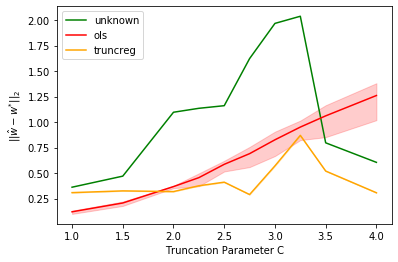

In [290]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown_logs, x='c', y='unknown_param_mse', label='unknown', color='green')
# sns.lineplot(data=known_logs, x='c', y='known_param_mse', color='blue', label='known')
sns.lineplot(data=logs, x='c', y='ols_param_mse', label='ols', color='red')
sns.lineplot(data=truncreg_logs, x='c', y='trunc_reg_param_mse', label='truncreg', color='orange')
plt.xlabel('Truncation Parameter C')
plt.ylabel('$||\hat w - w^{*}||_{2}$')
plt.show()

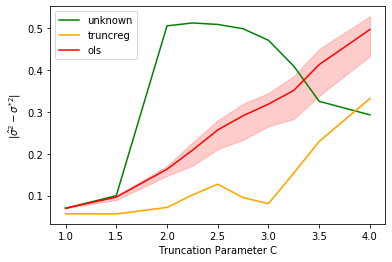

In [291]:
# plot results for regression noise variance MSE
sns.lineplot(data=unknown_logs, x='c', y='unknown_var_l1', label='unknown', color="green")
sns.lineplot(data=truncreg_logs, x='c', y='trunc_reg_var_l1', label='truncreg', color='orange')
ax = sns.lineplot(data=logs, x='c', y='ols_var_l1', label='ols', color="red")
plt.xlabel('Truncation Parameter C')
plt.ylabel('$|\hat \sigma^{2} - \sigma^{*2}|$')
plt.show()

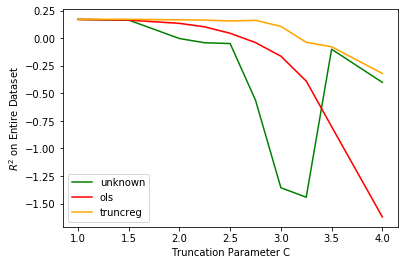

In [292]:
# plot results for regression parameter MSE
# sns.lineplot(data=known_logs, x='c', y='known_r2', label='known', color='blue')
sns.lineplot(data=unknown_logs, x='c', y='unknown_r2', label='unknown', color='green')
sns.lineplot(data=logs, x='c', y='ols_r2', label='ols', color='red')
sns.lineplot(data=truncreg_logs, x='c', y='trunc_reg_r2', label='truncreg', color='orange')
plt.xlabel('Truncation Parameter C')
plt.ylabel('$R^{2}$ on Entire Dataset')
plt.show()

In [255]:
indices

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  96,  97,  98,
         99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126,
        128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
        170, 171, 173, 174, 175, 176, 177, 178, 179, 180, 181, 1